<h1 align="center"> Project: Sentiment Analysis and Correlation Analysis</h1>

# Introduction
This project focuses on the detailed analysis of a large corpus of financial news data to discover correlations between news sentiment and stock market movements. The dataset for this project is FNSPID (Financial News and Stock Price Integration Dataset). It is a comprehensive financial dataset designed to enhance stock market predictions by combining quantitative and qualitative data.

To conduct this project, I will use two datasets: one provided by 10 academy (raw_analyst_ratings.csv) and the other financial data downloaded using the `yfinance` library. I will utilize various Python modules to perform this analysis.

In [1]:
# import reqiuared libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import concurrent.futures
import re
from nltk.stem.porter import PorterStemmer
#from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import talib
import ffn

# Data Gathering 

In [2]:
stock_df = pd.read_csv("../data/raw_analyst_ratings.csv")

# Assessing Data

## Visual Assessement

In [3]:
stock_df

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A
...,...,...,...,...,...,...
1407323,1413844,Top Narrow Based Indexes For August 29,https://www.benzinga.com/news/11/08/1888782/to...,Monica Gerson,2011-08-29 00:00:00,ZX
1407324,1413845,Recap: Wednesday's Top Percentage Gainers and ...,https://www.benzinga.com/news/earnings/11/06/1...,Benjamin Lee,2011-06-22 00:00:00,ZX
1407325,1413846,UPDATE: Oppenheimer Color on China Zenix Auto ...,https://www.benzinga.com/analyst-ratings/analy...,BenzingaStaffL,2011-06-21 00:00:00,ZX
1407326,1413847,Oppenheimer Initiates China Zenix At Outperfor...,https://www.benzinga.com/analyst-ratings/price...,Joe Young,2011-06-21 00:00:00,ZX


There is one unnecessary column named "Unnamed: 0

## Programmatic Assessement

In [4]:
stock_df.isna().sum()

Unnamed: 0    0
headline      0
url           0
publisher     0
date          0
stock         0
dtype: int64

In [5]:
stock_df.duplicated().sum()

0

In [6]:
stock_df.dtypes

Unnamed: 0     int64
headline      object
url           object
publisher     object
date          object
stock         object
dtype: object

The `date` column contains an erroneous data type.

## Quality issues
1. There is one unnecessary column named `Unnamed: 0`.
2. The `date` column contains an erroneous data type.

# Data Cleaning
## Quality issues

In [9]:
# make copy
stock_df_copy = stock_df.copy()

### Issue #1
There is one unnecessary column named Unnamed: 0

### Define
Unnamed:0 column is unnecessary for my analysis, so I use pandas `drop` method to remove this column from the data. 

### Code

In [4]:
stock_df_copy.drop('Unnamed: 0', axis=1, inplace=True)

### Test

In [5]:
stock_df_copy.columns

Index(['headline', 'url', 'publisher', 'date', 'stock'], dtype='object')

### Issue #2
The date column contains an erroneous data type.

### Define
The date column is an object data type but it should be datetime data type, I use `to_datetime` pandas method to convert the object type into datetime.

### Code

In [10]:
#remove -4:00 from the dataset
stock_df_copy['date']=stock_df_copy['date'].str.rstrip('-04:00')

# convert data type and format
stock_df_copy['date'] = pd.to_datetime(stock_df_copy.date, format='mixed', errors='coerce').dt.strftime('%Y-%m-%d')
stock_df_copy['date'] = pd.to_datetime(stock_df_copy.date)

In [11]:
stock_df_copy.dropna(inplace=True)

### Test

In [12]:
stock_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1407287 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   Unnamed: 0  1407287 non-null  int64         
 1   headline    1407287 non-null  object        
 2   url         1407287 non-null  object        
 3   publisher   1407287 non-null  object        
 4   date        1407287 non-null  datetime64[ns]
 5   stock       1407287 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 75.2+ MB


# Analysis and Visualization

## Descriptive Statistics
1. Obtain basic statistics for textual lengths (like headline length).


In [9]:
# Calculate the average headline length
average_headline_length = stock_df_copy['headline'].str.len().mean()
print("Average Headline Length: {:.2f}".format(average_headline_length))

Average Headline Length: 73.12


The average headline length is `73.12`.

2. Count the number of articles per publisher to identify which publishers are most active.

In [14]:
# Count articles per publisher
stock_df_copy['publisher'].value_counts()

publisher
Paul Quintaro                      228372
Lisa Levin                         186975
Benzinga Newsdesk                  150476
Charles Gross                       96732
Monica Gerson                       82380
                                    ...  
Shazir Mucklai - Imperium Group         1
Laura Jennings                          1
Eric Martin                             1
Jose Rodrigo                            1
Jeremie Capron                          1
Name: count, Length: 1034, dtype: int64

Text(0, 0.5, 'Number of Articles')

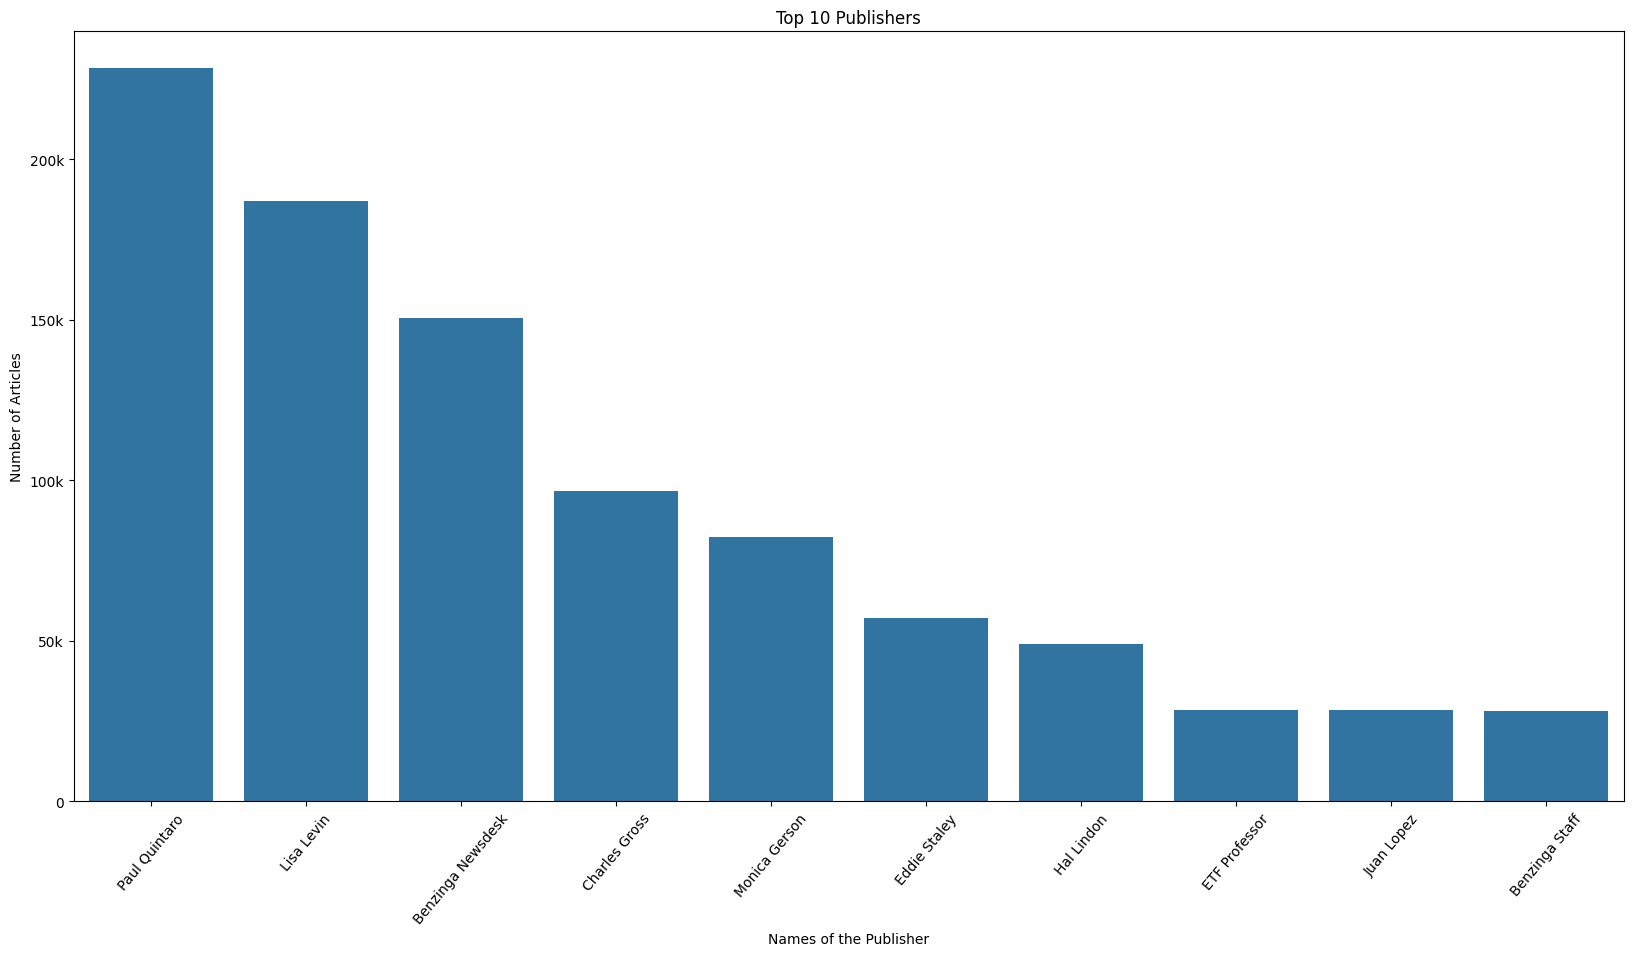

In [15]:
# plot top 10 publishers
df = stock_df['publisher'].value_counts().reset_index().sort_values(by='count', ascending=False).head(10)
plt.figure(figsize=(20, 10))
sns.barplot(x = 'publisher', y = 'count', data=df)
plt.title('Top 10 Publishers')
plt.xlabel('Names of the Publisher')
plt.xticks(rotation=50)
plt.yticks([0, 50000, 100000, 150000, 200000], [0, '50k', '100k', '150k', '200k'])
plt.ylabel('Number of Articles')

The above bar plot shows the top 10 publishers based on the dataset. Paul Quintaro has the highest count at 228,372, suggesting he is the most prolific publisher among the listed ones, contributing significantly to the dataset. Lisa Levin follows with a count of 186,975, making her the second most prolific publisher, indicating a substantial presence in the dataset. Benzinga Newsdesk comes in third with a count of 150,476, further highlighting its significant contribution.


3. Analyze the publication dates to see trends over time, such as increased news frequency on particular days or during specific events.

In [16]:
df = stock_df_copy.copy()
df = df.set_index(pd.DatetimeIndex(df['date']))
df1 = df.resample('YE').size()

Text(0, 0.5, 'Number of Articles')

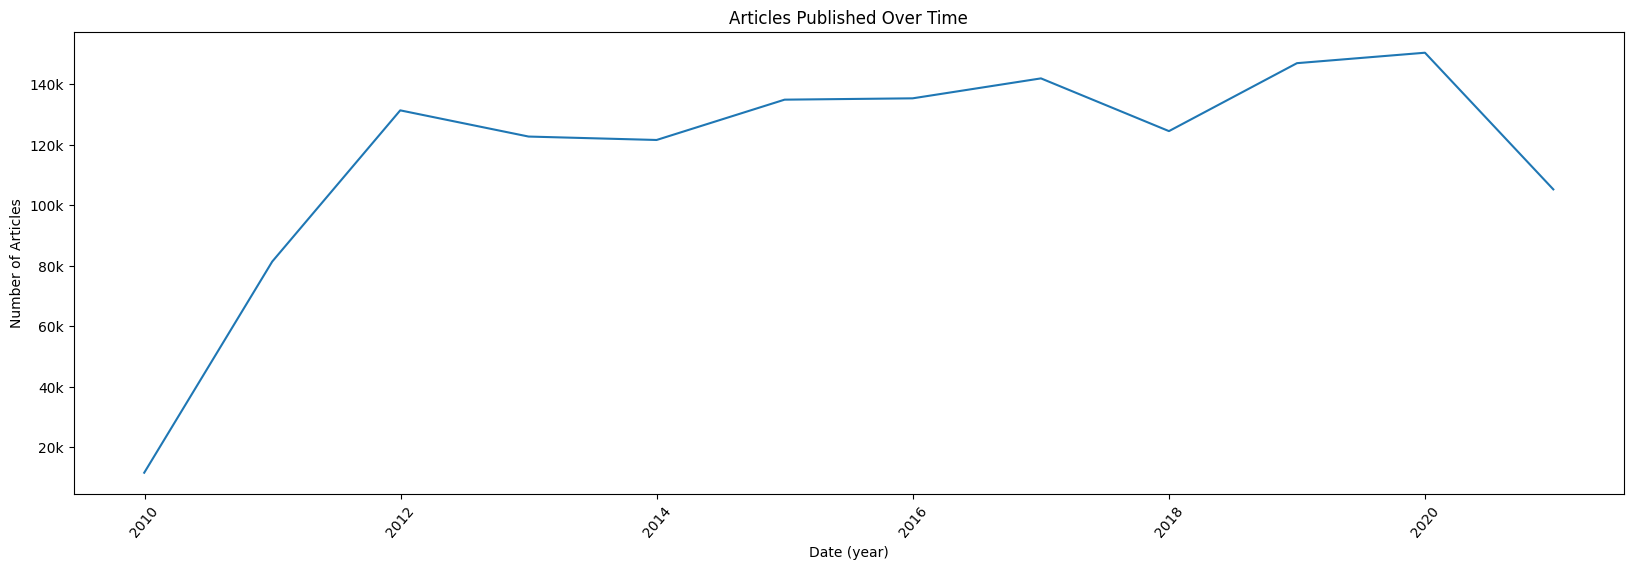

In [17]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=df1)
sns.set(style='darkgrid')
plt.title('Articles Published Over Time')
plt.xlabel('Date (year)')
plt.xticks(rotation=50)
plt.yticks([20000, 40000, 60000, 80000, 100000, 120000, 140000], ['20k', '40k','60k', '80k', '100k', '120k', '140k'])
plt.ylabel('Number of Articles')

As can be seen from the above line plot, the publication rate appears flat from 2012 to 2017, indicating a period of relative consistency. The frequency of publications decreased between 2017 and 2018. After 2018, there is a significant increase in the number of publications. The year 2020 shows the highest frequency of publications.

## Text Analysis(Sentiment analysis & Topic Modeling)
1. Perform sentiment analysis on headlines to gauge the sentiment (positive, negative, neutral) associated with the news.

In [10]:
corpus = []

for headline in stock_df_copy['headline']:
    # Remove punctuation and convert to lowercase
    headline = re.sub('[^a-zA-Z]', ' ', headline).lower()
    # Tokenize the headline
    headline = headline.split()
    # Apply stemming
    ps = PorterStemmer()
    #all_stopwords = stopwords.words('english')
    #no_stopwords = ["not", "don't", "aren", "don", "ain", "aren't", "couldn", "couldn't", "wasn't"]
    #for Nostopword in no_stopwords:
    #   all_stopwords.remove(Nostopword)
    headline = [ps.stem(word) for word in headline]
    corpus.append(headline)

In [13]:
# Function to analyze sentiment
def analyze_sentiment(text):
    blob = TextBlob(text)
    if blob.sentiment.polarity > 0:
        return 'Positive'
    elif blob.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment analysis to the corpus
sentiments = [analyze_sentiment(' '.join(headline)) for headline in corpus]

# Update stock_df with sentiment scores
stock_df_copy['sentiment'] = sentiments
stock_df_copy.head(5)

,headline,url,publisher,date,stock,sentiment
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05,A,Positive
1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03,A,Positive
2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26,A,Neutral
3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22,A,Neutral
4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22,A,Neutral


2. Use natural language processing to identify common keywords or phrases, potentially extracting topics or significant events (like "FDA approval", "price target", etc.).

## Time Series Analysis:
1. How does the publication frequency vary over time? Are there spikes in article publications related to specific market events?
Analysis of publishing times might reveal if there’s a specific time when most news is released, which could be crucial for traders and automated trading systems.

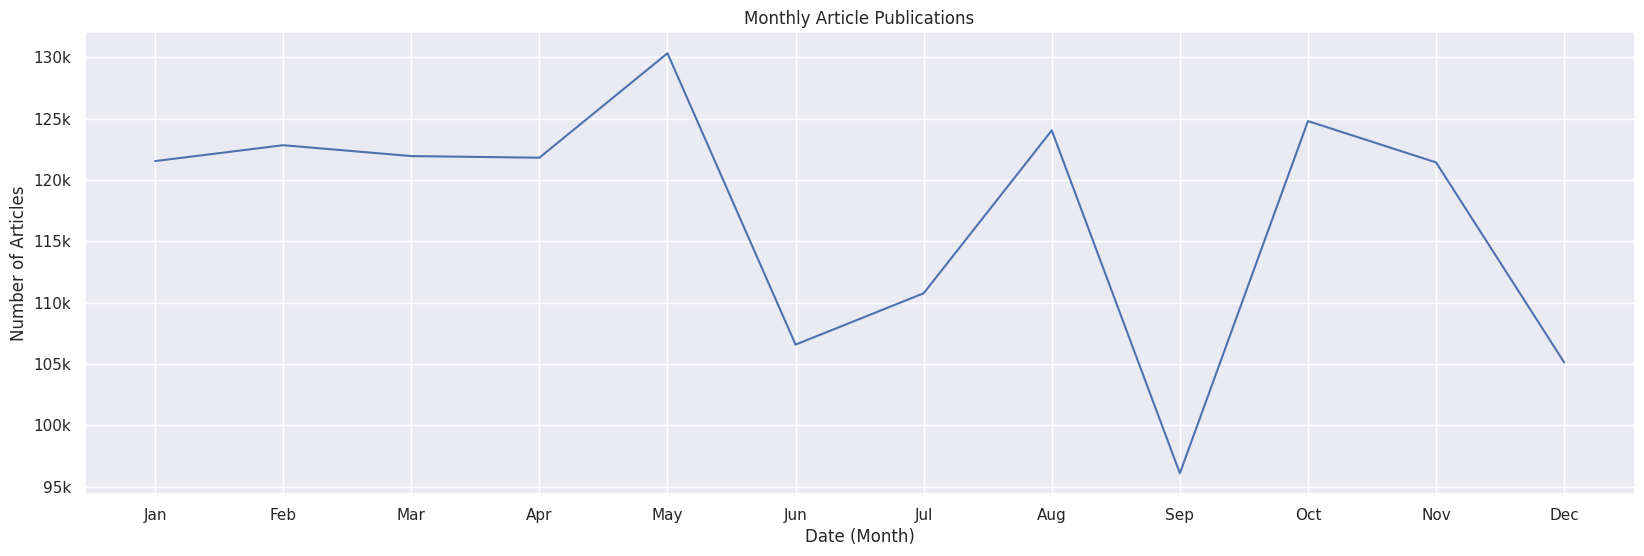

In [18]:
# Group by date and count articles
monthly_articles = stock_df_copy.groupby(stock_df_copy['date'].dt.month).size()
# Define the months
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plotting monthly articles
plt.figure(figsize=(20, 6))
monthly_articles.plot(kind='line')
plt.title('Monthly Article Publications')
plt.xlabel('Date (Month)')
plt.ylabel('Number of Articles')
plt.xticks(np.arange(1, 13), months)
plt.yticks([95000, 100000, 105000, 110000, 115000, 120000, 125000, 130000], ['95k','100k', '105k', '110k', '115k', '120k', '125k', '130k'])
plt.show()

The results of a line plot that shows publication trends over several months. 
- May: There's a significant spike in publications, indicating a much higher number compared to other months.
- September: Publication numbers dip considerably, showing the lowest point on the line.
- January to April: The line seems relatively flat, suggesting a consistent and stable number of publications throughout these months.

## Publisher Analysis:
1. Which publishers contribute most to the news feed? Is there a difference in the type of news they report?
2. If email addresses are used as publisher names, identify unique domains to see if certain organizations contribute more frequently.

In [19]:
#stock_df_copy['domain'] = stock_df_copy['publisher'].str.extract(r'@(\w+)', expand=False)

# Counting unique publishers
unique_domains = stock_df_copy['publisher'].nunique()
print(f"Number of Unique Domains: {unique_domains}")

Number of Unique Domains: 1034


Text(0.5, 0, 'Number of Articles')

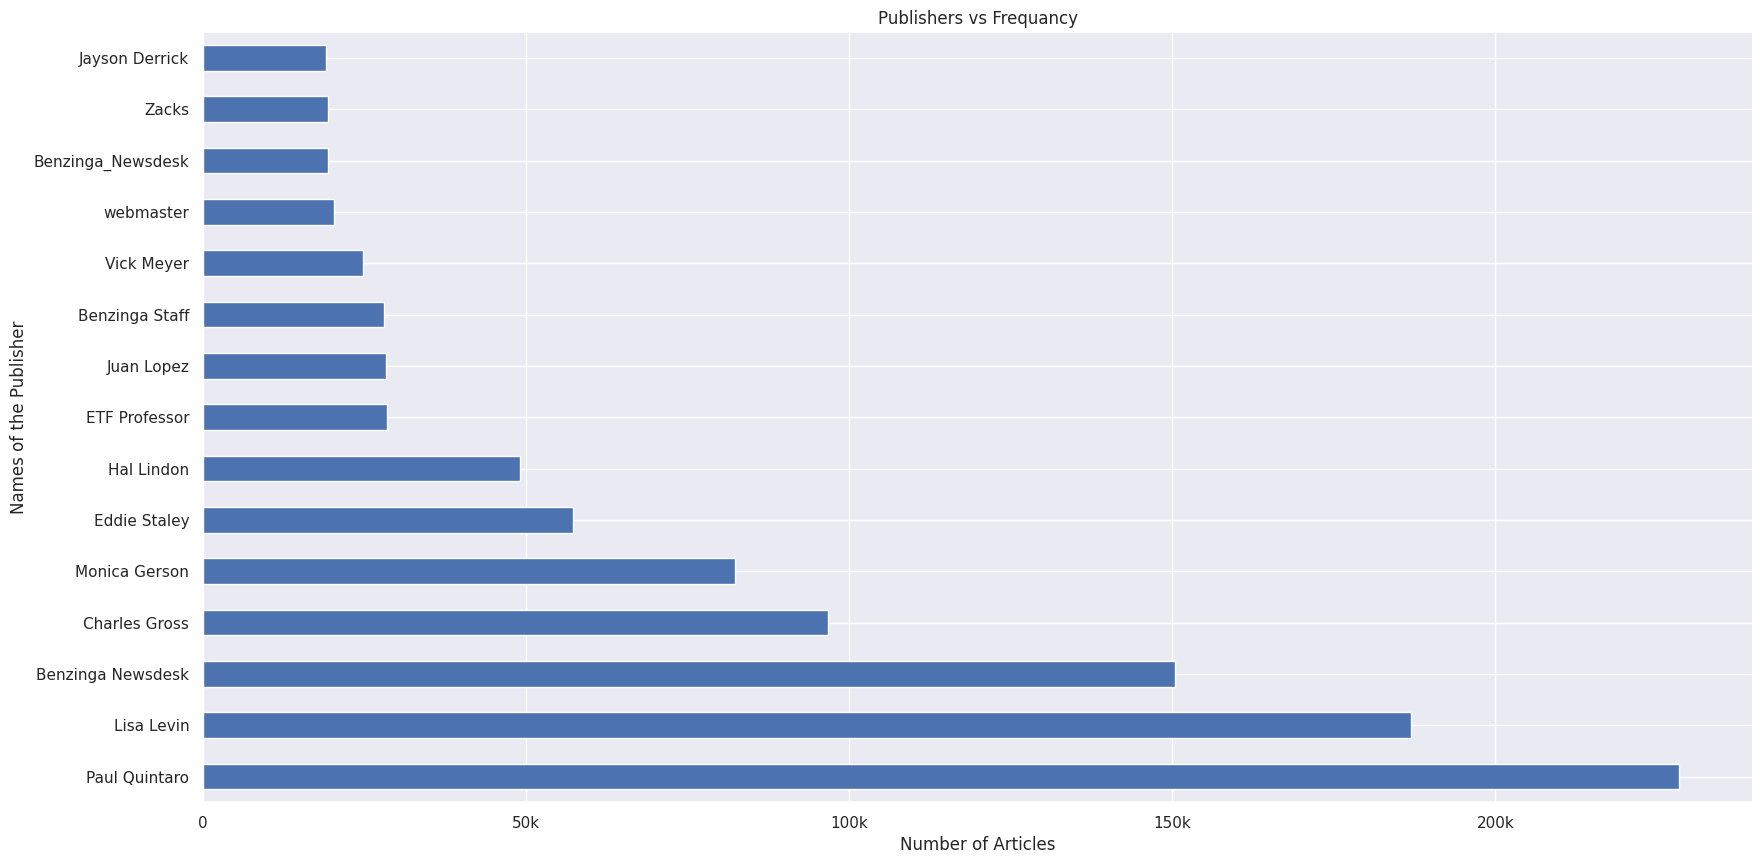

In [20]:
# Analyzing contributions of publisher
#contributions_by_domain = stock_df_copy['publisher'].value_counts()
#print(contributions_by_domain)
plt.figure(figsize=(20, 10))
stock_df_copy['publisher'].value_counts()[:15].plot(kind='barh')
plt.title('Publishers vs Frequancy')
plt.ylabel('Names of the Publisher')
plt.xticks([0, 50000, 100000, 150000, 200000], [0, '50k', '100k', '150k', '200k'])
plt.xlabel('Number of Articles')

The bar plot indicates that Paul Quinto published a greater number of articles than the other publishers.

# Storing Data

In [14]:
stock_df_copy.to_csv("../data/stock_news_clean.csv")

# Stock price fetching using `yfinance`

In [13]:
stock_df_copy['stock'].nunique()

6204

In [14]:
stock_price_data = stock_df_copy.groupby("stock").size().reset_index(name='counts')
stock_price_data = stock_price_data[stock_price_data['counts'] > 400]
tickers = stock_price_data['stock']

In [15]:
# Calculate the earliest and latest dates for each stock
earliest_dates = stock_df_copy.groupby('stock')['date'].min()
latest_dates = stock_df_copy.groupby('stock')['date'].max()

# Convert the series to dictionaries for easier access
earliest_dates_dict = earliest_dates.to_dict()
latest_dates_dict = latest_dates.to_dict()

In [72]:
# try to download stock price data for 6224 tickers
''' 
tickers = stock_df_copy.stock.value_counts().reset_index()['stock']

def download_data(tickers):
    yahoo_df = pd.DataFrame()

    def download_batch(batch_tickers):
        batch_df = pd.DataFrame()
        for ticker in batch_tickers:
            try:
                start_date = earliest_dates_dict[ticker]
                end_date = latest_dates_dict[ticker]
                df = yf.download(ticker, group_by='Ticker', start=start_date, end=end_date).assign(ticker=ticker)
                batch_df = pd.concat([batch_df, df], ignore_index=True)
            except Exception as e:
                print(f"Error downloading {ticker}: {e}")
        return batch_df

    # Divide tickers into batches
    batch_size = 100  # Adjust based on your preference or API limitations
    batches = [tickers[i:i + batch_size] for i in range(0, len(tickers), batch_size)]

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(download_batch, batch) for batch in batches]
        for future in concurrent.futures.as_completed(futures):
            batch_df = future.result()
            if batch_df.empty:
                print(f"Batch DataFrame is empty.")
            else:
                yahoo_df = pd.concat([yahoo_df, batch_df], ignore_index=True)

    return yahoo_df


yahoo_df = download_data(tickers)
'''
pass

In [19]:
#tickers = stock_df_copy.stock.value_counts().reset_index()['stock']
def download_data(tickers):
    yahoo_df = pd.DataFrame()
    for ticker in tickers:
        try:
            # Get the earliest and latest dates for the current ticker
            start_date = earliest_dates_dict[ticker]
            end_date = latest_dates_dict[ticker]
            
            # Download data for the ticker
            df = yf.download(ticker, threads=True, group_by='Ticker', start=start_date, end=end_date).assign(ticker=ticker)
            yahoo_df = pd.concat([yahoo_df, df], ignore_index=False)
        except Exception as e:
            print(f"Error downloading {ticker}: {e}")
    return yahoo_df
yahoo_df = download_data(tickers)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['AAN']: Exception("%ticker%: Data doesn't exist for startDate = 1249876800, endDate = 1591761600")
/tmp/ipykernel_30259/3201080820.py:12: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  yahoo_df = pd.concat([yahoo_df, df], ignore_index=False)
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%********

In [20]:
yahoo_df.head()

,Open,High,Low,Close,Adj Close,Volume,ticker
Date,,,,,,,
2009-04-29,12.310443,13.011445,12.238913,12.896996,11.591174,5516508.0,A
2009-04-30,12.947067,13.547926,12.947067,13.061516,11.739035,4977998.0,A
2009-05-01,13.025751,13.590844,13.004292,13.454936,12.092623,4039241.0,A
2009-05-04,13.454936,13.891273,13.412017,13.891273,12.484777,3885042.0,A
2009-05-05,13.848355,13.876967,13.283262,13.397711,12.041191,4895656.0,A


In [21]:
yahoo_df.to_csv("../data/stock_price.csv")

# Quantitative analysis

In [2]:
stock_price_df = pd.read_csv("../data/stock_price.csv")
stock_price_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ticker
0,2009-04-29,12.310443,13.011445,12.238913,12.896996,11.591174,5516508.0,A
1,2009-04-30,12.947067,13.547926,12.947067,13.061516,11.739035,4977998.0,A
2,2009-05-01,13.025751,13.590844,13.004292,13.454936,12.092623,4039241.0,A
3,2009-05-04,13.454936,13.891273,13.412017,13.891273,12.484777,3885042.0,A
4,2009-05-05,13.848355,13.876967,13.283262,13.397711,12.041191,4895656.0,A


In [3]:
stock_price_df.Date = pd.to_datetime(stock_price_df.Date)

In [4]:
# set the date column as an index
stock_price_df.set_index('Date', inplace=True)

In [5]:
stock_price_df.head()

,Open,High,Low,Close,Adj Close,Volume,ticker
Date,,,,,,,
2009-04-29,12.310443,13.011445,12.238913,12.896996,11.591174,5516508.0,A
2009-04-30,12.947067,13.547926,12.947067,13.061516,11.739035,4977998.0,A
2009-05-01,13.025751,13.590844,13.004292,13.454936,12.092623,4039241.0,A
2009-05-04,13.454936,13.891273,13.412017,13.891273,12.484777,3885042.0,A
2009-05-05,13.848355,13.876967,13.283262,13.397711,12.041191,4895656.0,A


In [5]:
# check nan value
stock_price_df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
ticker       0
dtype: int64

### Financial Metrics using `ffn`

In [7]:
# Calculate daily returns
returns = stock_price_df['Adj Close'].pct_change()

# Calculate performance statistics (replace with desired stats)
stats = {
    'Average Daily Return': returns.mean(),
    'Standard Deviation': returns.std()
}

print("Performance Statistics:")
for stat, value in stats.items():
    print(f"{stat}: {value}")

# Plot the closing prices (replace with desired plot)
#stock_price_df['Adj Close'].plot(title='Stock Prices')

Performance Statistics:
Average Daily Return: 327882.40428771183
Standard Deviation: 425018795.1197659


### Analysis Indicators with `TA-Lib`

In [13]:
# Calculate SMAs
stock_price_df['SMA_50'] = talib.SMA(stock_price_df['Close'], timeperiod=50)
stock_price_df['SMA_200'] = talib.SMA(stock_price_df['Close'], timeperiod=200)
    
# Calculate RSI
stock_price_df['RSI'] = talib.RSI(stock_price_df['Close'])
    
# Calculate MACD
macd, macdsignal, macdhist = talib.MACD(stock_price_df['Close'])
stock_price_df['MACD'] = macd
stock_price_df['MACDSignal'] = macdsignal
stock_price_df['MACDHist'] = macdhist

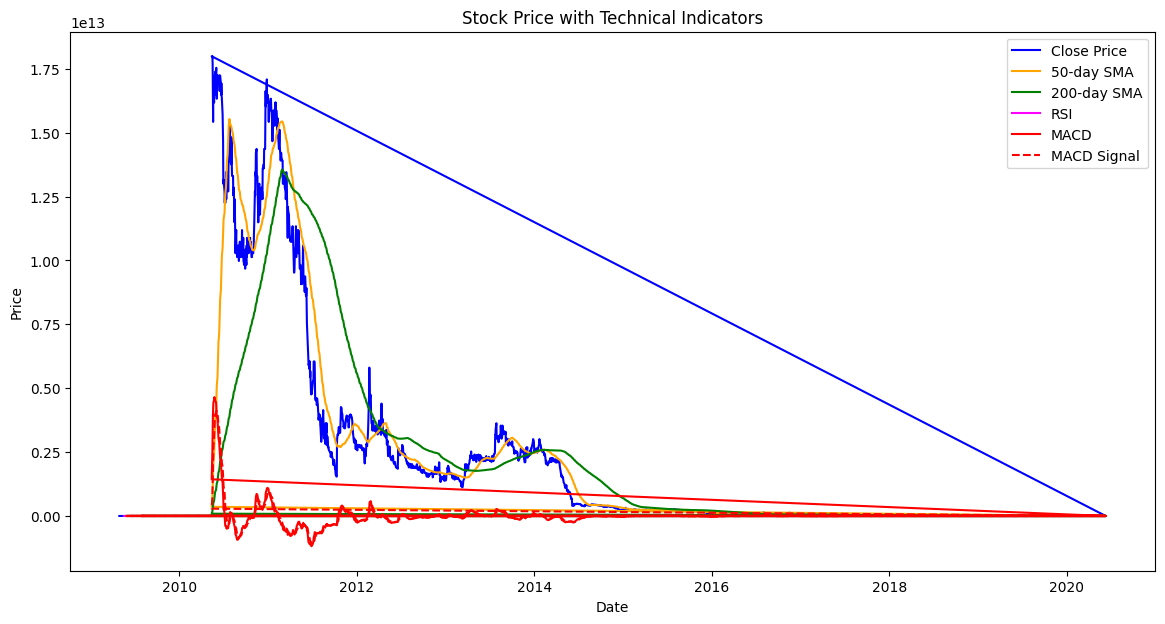

In [14]:
plt.figure(figsize=(14, 7))

# Plot closing price
plt.plot(stock_price_df['Close'], label='Close Price', color='blue')

# Plot SMAs
plt.plot(stock_price_df['SMA_50'], label='50-day SMA', linestyle='-', color='orange')
plt.plot(stock_price_df['SMA_200'], label='200-day SMA', linestyle='-', color='green')

# Plot RSI
plt.plot(stock_price_df['RSI'], label='RSI', linestyle='-', color='magenta')

# Plot MACD
plt.plot(stock_price_df['MACD'], label='MACD', linestyle='-', color='red')
plt.plot(stock_price_df['MACDSignal'], label='MACD Signal', linestyle='--', color='red')

plt.title('Stock Price with Technical Indicators')
plt.xlabel('Date')
plt.ylabel('Price')
#plt.xticks([])
plt.legend()
plt.show()

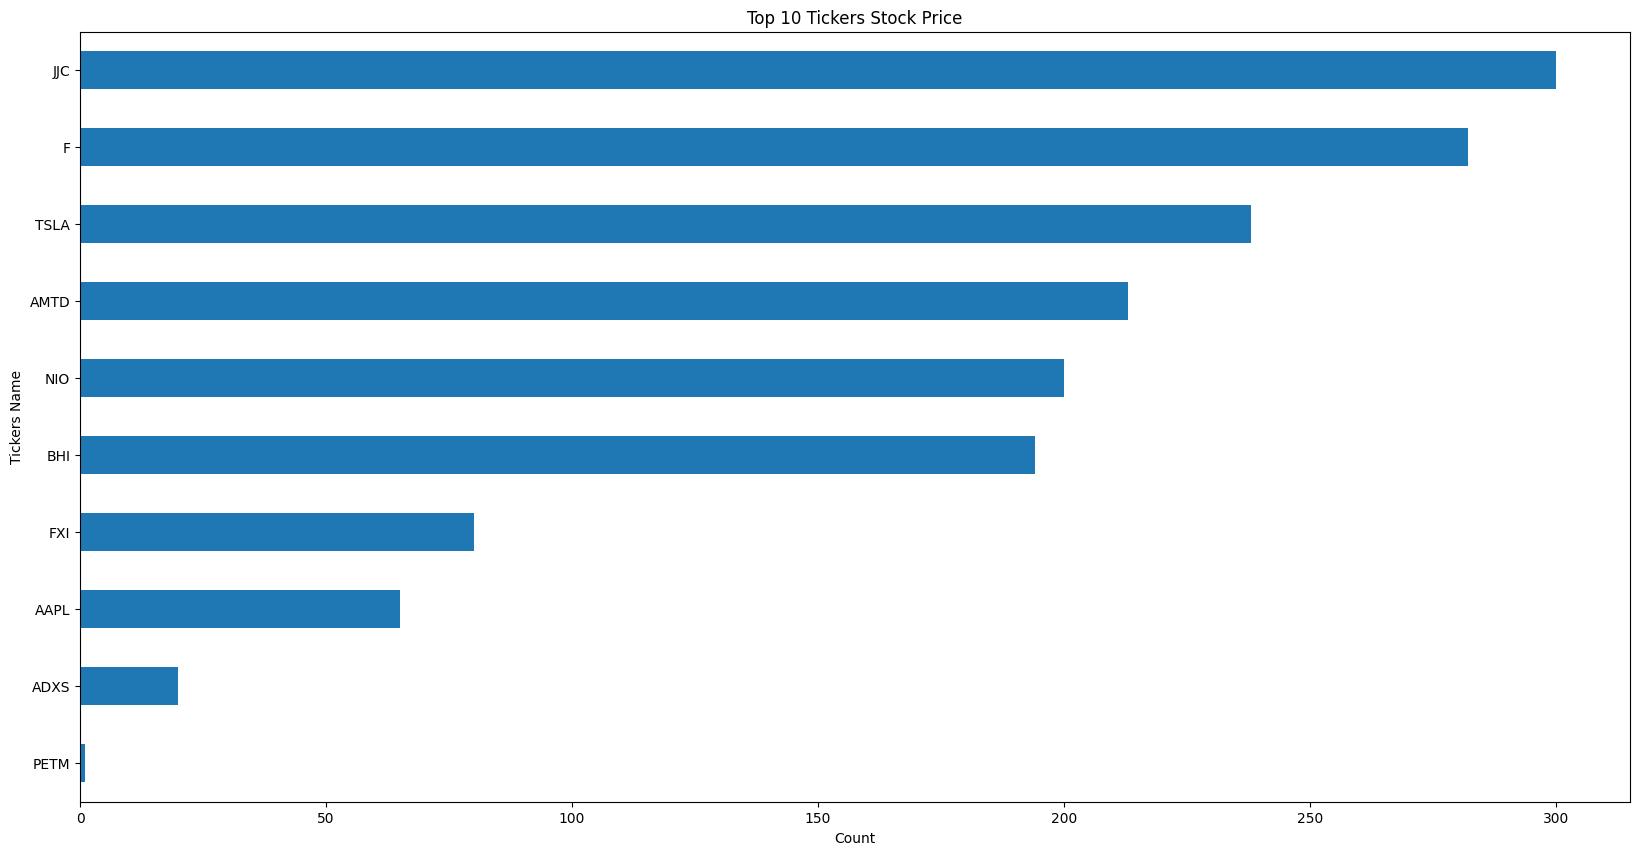

In [14]:
plt.figure(figsize=(20, 10))
stock_price_df.groupby('ticker').size().sort_values()[:10].plot(kind='barh')
plt.title('Top 10 Tickers Stock Price')
plt.ylabel('Tickers Name')
plt.xlabel('Count')
plt.show()

## Correlation between news and stock movement
Tasks:
- Date Alignment: Ensure that both datasets (news and stock prices) are aligned by dates. This might involve normalizing timestamps.
- Sentiment Analysis: Conduct sentiment analysis on news headlines to quantify the tone of each article (positive, negative, neutral).Tools: Use Python libraries like nltk, TextBlob for sentiment analysis.
- Analysis:
   - Calculate Daily Stock Returns: Compute the percentage change in daily closing prices to represent stock movements.
   - Correlation Analysis: Use statistical methods to test the correlation between daily news sentiment scores and stock returns.


In [3]:
stock_news_df= pd.read_csv("../data/stock_news_clean.csv")

In [4]:
stock_news_df['date'] = pd.to_datetime(stock_news_df['date'])

In [5]:
stock_news_df.dtypes

Unnamed: 0             int64
headline              object
url                   object
publisher             object
date          datetime64[ns]
stock                 object
sentiment             object
dtype: object

In [5]:
#stock_price_df.reset_index(inplace = True)
stock_price_df['Date'] = pd.to_datetime(stock_price_df['Date'])

In [6]:
# Convert columns to lowercase
stock_price_df.columns = stock_price_df.columns.str.lower()

In [7]:
stock_price_df.dtypes

date         datetime64[ns]
open                float64
high                float64
low                 float64
close               float64
adj close           float64
volume              float64
ticker               object
dtype: object

In [16]:
# Set 'date' as the index for both DataFrames
#stock_news_df.set_index('date', inplace=True)
#stock_price_df.set_index('date', inplace=True)

### Sentiment Analysis

In [20]:
corpus = []

for headline in stock_news_df['headline']:
    # Remove punctuation and convert to lowercase
    headline = re.sub('[^a-zA-Z]', ' ', headline).lower()
    # Tokenize the headline
    headline = headline.split()
    # Apply stemming
    ps = PorterStemmer()
    #all_stopwords = stopwords.words('english')
    #no_stopwords = ["not", "don't", "aren", "don", "ain", "aren't", "couldn", "couldn't", "wasn't"]
    #for Nostopword in no_stopwords:
    #   all_stopwords.remove(Nostopword)
    headline = [ps.stem(word) for word in headline]
    corpus.append(headline)

In [23]:
'''
# Function to analyze sentiment
def analyze_sentiment(text):
    blob = TextBlob(text)
    stock_news_df['sentiment_score'] = blob.sentiment.polarity
    if blob.sentiment.polarity > 0:
        return 'Positive'
    elif blob.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment analysis to the corpus
sentiments = [analyze_sentiment(' '.join(headline)) for headline in corpus]

# Update stock_df with sentiment scores
stock_news_df['sentiment'] = sentiments
stock_news_df.head(5)
'''
pass

###  Calculate Daily Stock Returns
To calculate daily stock returns, I will use the percentage change in closing prices.

In [14]:
# Calculate daily returns
stock_price_df['daily_return'] = stock_price_df['close'].pct_change()
stock_price_df.head()

,date,open,high,low,close,adj close,volume,ticker,daily_return
0,2009-04-29,12.310443,13.011445,12.238913,12.896996,11.591174,5516508.0,A,NaN
1,2009-04-30,12.947067,13.547926,12.947067,13.061516,11.739035,4977998.0,A,0.012756
2,2009-05-01,13.025751,13.590844,13.004292,13.454936,12.092623,4039241.0,A,0.030121
3,2009-05-04,13.454936,13.891273,13.412017,13.891273,12.484777,3885042.0,A,0.032429
4,2009-05-05,13.848355,13.876967,13.283262,13.397711,12.041191,4895656.0,A,-0.035530


### Correlation Analysis

In [10]:
#stock_news_df.reset_index(inplace=True)
#stock_price_df.reset_index(inplace=True)

In [9]:
#merged_df = pd.merge(stock_news_df, stock_price_df, on='date')

In [15]:
correlation = stock_price_df.groupby('ticker').corr(method='pearson')
print(correlation)

                         date      open      high       low     close  \
ticker                                                                  
A      date          1.000000  0.944817  0.945181  0.944794  0.944911   
       open          0.944817  1.000000  0.999722  0.999709  0.999428   
       high          0.945181  0.999722  1.000000  0.999570  0.999711   
       low           0.944794  0.999709  0.999570  1.000000  0.999715   
       close         0.944911  0.999428  0.999711  0.999715  1.000000   
...                       ...       ...       ...       ...       ...   
ZUMZ   low          -0.054486  0.997548  0.996898  1.000000  0.997860   
       close        -0.055048  0.995317  0.997781  0.997860  1.000000   
       adj close    -0.055048  0.995317  0.997781  0.997860  1.000000   
       volume        0.045926 -0.092689 -0.072894 -0.111939 -0.094174   
       daily_return  0.008570 -0.007833  0.024598  0.022375  0.054975   

                     adj close    volume  daily_re